The image files were collected from https://shahariarrabby.github.io/ekush/#download and stored in my Google Drive.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tqdm import tqdm

from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

import pathlib

import seaborn as sns
import pandas as pd

from google.colab import drive 
drive.mount('/content/gdrive')

#The data from the site was uploaded to my drive
data_dir = "gdrive/My Drive/bangla_data_final"

!pip install keras-tuner

import keras_tuner as kt


In [ ]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1. / 255,
    validation_split = 0.2) 

batch_size = 32
img_height = 160
img_width = 160


train_generator = data_generator.flow_from_directory(
    data_dir, 
    target_size =(img_width, img_height), 
    batch_size = batch_size,
    shuffle = True,
    class_mode = 'sparse',
    seed = 42,
    subset='training')

validation_generator = data_generator.flow_from_directory( 
    data_dir, 
    target_size =(img_width, img_height), 
    batch_size = batch_size,
    shuffle = True,
    class_mode = 'sparse',
    seed = 42,
    subset='validation')

Found 24003 images belonging to 50 classes.
Found 5997 images belonging to 50 classes.


In [ ]:
# Store the data in X_train, y_train variables by iterating over the batches
train_generator.reset()
X_train, y_train = next(train_generator)
for i in tqdm(range(int(len(train_generator)/batch_size)-1)): #1st batch is already fetched before the for loop.
  img, label = next(train_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

100%|██████████| 22/22 [00:48<00:00,  2.22s/it]

(736, 160, 160, 3) (736,)


In [ ]:
# Store the data in X_train, y_train variables by iterating over the batches
validation_generator.reset()
X_test, y_test = next(validation_generator)
for i in tqdm(range(int(len(validation_generator)/batch_size)-1)): #1st batch is already fetched before the for loop.
  img, label = next(validation_generator)
  X_test = np.append(X_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

100%|██████████| 4/4 [00:46<00:00, 11.67s/it]

(160, 160, 160, 3) (160,)


In [ ]:

def model_builder(hp):
  
  #Tuning each of the model's components with the Hyperband tuner
  hp_activation = hp.Choice(
      'dense_activation',
      values=['relu', 'softmax'],
       default='relu')
  
  hp_units = hp.Int(
      'units', 
      min_value=32, 
      max_value=512, 
      step=16)
  
  model = keras.Sequential()

  model.add(tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(160, 160, 3)))
  model.add(tf.keras.layers.Conv2D( 
      filters = hp.Choice(
      'num_filters_1',
      values=[16, 32, 64],
      default=64), kernel_size =  3, activation='relu'))
  
  model.add(tf.keras.layers.MaxPooling2D(pool_size=hp.Choice(
      'pool_1',
      values=[2,3],
      default=2)))

  model.add(tf.keras.layers.Conv2D(
      filters = hp.Choice(
      'num_filters_2',
      values=[32, 64],
      default=64), 
      kernel_size = 3, activation='relu'))
  
  model.add(tf.keras.layers.MaxPooling2D(pool_size=hp.Choice(
      'pool_2',
      values=[2,3],
      default=2)))
  
  model.add(tf.keras.layers.Conv2D( 
      filters = hp.Choice(
      'num_filters_3',
      values=[32, 64, 128],
      default=64), kernel_size =  3, activation='relu'))
  
  model.add(tf.keras.layers.MaxPooling2D(pool_size=hp.Choice(
      'pool_3',
      values=[2,3],
      default=2)))
  
  model.add(tf.keras.layers.Dropout(
                rate=hp.Float(
                    'dropout_3',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.1
                )
            ))
  
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units= hp_units,activation='relu'))
  
  model.add(tf.keras.layers.Dense(50, activation=hp_activation))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     seed = 7,
                     executions_per_trial = 2,
                     directory='applied_AI_big_data',
                     project_name='hp_tuning_small_data_v11')



In [ ]:
tuner.search_space_summary()


Search space summary
Default search space size: 10
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'softmax'], 'ordered': False}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 16, 'sampling': None}
num_filters_1 (Choice)
{'default': 64, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
pool_1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
num_filters_2 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
pool_2 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
num_filters_3 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
pool_3 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
dropout_3 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 

In [ ]:
#Early Stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')


In [ ]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 30 Complete [00h 15m 34s]
val_accuracy: 0.26013512909412384

Best val_accuracy So Far: 0.2871621549129486
Total elapsed time: 03h 09m 19s
INFO:tensorflow:Oracle triggered exit


In [ ]:

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. The optimal number of filters in the first convolution layer is {best_hps.get('num_filters_1')}, in the second one it's {best_hps.get('num_filters_2')},
and in the third one it's {best_hps.get('num_filters_3')}. The optimal dropout rate is {best_hps.get('dropout_3')} and the optimal activation function in 
the output layer is {best_hps.get('dense_activation')}. The first, second, and third max_pooling filters' pool sizes are {best_hps.get('pool_1')}, {best_hps.get('pool_2')}, 
and {best_hps.get('pool_3')} respectively.
""")

In [ ]:
tuner.results_summary()


Results summary
Results in applied_AI_big_data/hp_tuning_small_data_v11
Showing 10 best trials
Trial summary
Hyperparameters:
dense_activation: softmax
units: 144
num_filters_1: 32
pool_1: 2
num_filters_2: 64
pool_2: 3
num_filters_3: 64
pool_3: 2
dropout_3: 0.5
learning_rate: 0.001
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.2871621549129486
Trial summary
Hyperparameters:
dense_activation: softmax
units: 416
num_filters_1: 32
pool_1: 2
num_filters_2: 32
pool_2: 3
num_filters_3: 128
pool_3: 2
dropout_3: 0.30000000000000004
learning_rate: 0.0001
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.2736486494541168
Trial summary
Hyperparameters:
dense_activation: softmax
units: 176
num_filters_1: 64
pool_1: 2
num_filters_2: 32
pool_2: 2
num_filters_3: 64
pool_3: 2
dropout_3: 0.4
learning_rate: 0.001
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.26013512909412384
Trial s

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
19/19 [==============================] - 35s 2s/step - loss: 3.9324 - accuracy: 0.0153 - val_loss: 3.9059 - val_accuracy: 0.0270
Epoch 2/20
19/19 [==============================] - 31s 2s/step - loss: 3.9013 - accuracy: 0.0255 - val_loss: 3.9212 - val_accuracy: 0.0135
Epoch 3/20
19/19 [==============================] - 31s 2s/step - loss: 3.8755 - accuracy: 0.0306 - val_loss: 3.8618 - val_accuracy: 0.0338
Epoch 4/20
19/19 [==============================] - 31s 2s/step - loss: 3.7324 - accuracy: 0.0714 - val_loss: 3.7365 - val_accuracy: 0.1081
Epoch 5/20
19/19 [==============================] - 31s 2s/step - loss: 3.3523 - accuracy: 0.1463 - val_loss: 3.4358 - val_accuracy: 0.1284
Epoch 6/20
19/19 [==============================] - 32s 2s/step - loss: 2.8853 - accuracy: 0.2347 - val_loss: 3.2924 - val_accuracy: 0.1757
Epoch 7/20
19/19 [==============================] - 31s 2s/step - loss: 2.3719 - accuracy: 0.3520 - val_loss: 3.1827 - val_accuracy: 0.2095
Epoch 8/20
19/19 [==

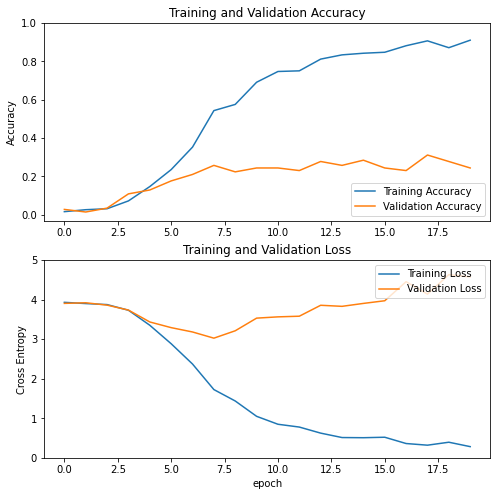

In [ ]:
#Training and validaton accuracy graphs

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Epoch 1/50
19/19 [==============================] - 32s 2s/step - loss: 3.9220 - accuracy: 0.0187 - val_loss: 3.9105 - val_accuracy: 0.0135
Epoch 2/50
19/19 [==============================] - 31s 2s/step - loss: 3.9067 - accuracy: 0.0289 - val_loss: 3.9072 - val_accuracy: 0.0135
Epoch 3/50
19/19 [==============================] - 31s 2s/step - loss: 3.8776 - accuracy: 0.0340 - val_loss: 3.9064 - val_accuracy: 0.0135
Epoch 4/50
19/19 [==============================] - 31s 2s/step - loss: 3.8006 - accuracy: 0.0595 - val_loss: 3.8905 - val_accuracy: 0.0338
Epoch 5/50
19/19 [==============================] - 31s 2s/step - loss: 3.5307 - accuracy: 0.0816 - val_loss: 3.7428 - val_accuracy: 0.0676
Epoch 6/50
19/19 [==============================] - 31s 2s/step - loss: 3.2346 - accuracy: 0.1752 - val_loss: 3.6706 - val_accuracy: 0.1014
Epoch 7/50
19/19 [==============================] - 31s 2s/step - loss: 2.6448 - accuracy: 0.3027 - val_loss: 3.5641 - val_accuracy: 0.1351
Epoch 8/50
19/19 [==

In [ ]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

5/5 [==============================] - 2s 419ms/step - loss: 4.1307 - accuracy: 0.2250
[test loss, test accuracy]: [4.13068151473999, 0.22499999403953552]


#Transfer Learning Starts

In [ ]:
batch_size = 64
img_height = 160
img_width = 160

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 30000 files belonging to 50 classes.
Using 24000 files for training.
Found 30000 files belonging to 50 classes.
Using 6000 files for validation.
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '6', '7', '8', '9']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## For all the models

In [ ]:
IMG_SIZE = (160,160)
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
bangla_test_data = "gdrive/My Drive/bangla_data_test"

In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(bangla_test_data,
                                                                 shuffle=True,
                                                                 batch_size=20,
                                                                 image_size=IMG_SIZE)

Found 3149 files belonging to 50 classes.


In [ ]:
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## ResNet

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')


In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(50, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 160, 160, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               262149

In [ ]:
len(model.trainable_variables)

4

In [ ]:
initial_epochs = 10


In [ ]:

loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

94/94 [==============================] - 22s 112ms/step - loss: 6.8152 - accuracy: 0.0173
initial loss: 6.82
initial accuracy: 0.02


In [ ]:
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds, callbacks = [stop_early])

Epoch 1/100
375/375 [==============================] - 85s 128ms/step - loss: 1.8322 - accuracy: 0.5203 - val_loss: 0.6778 - val_accuracy: 0.8145
Epoch 2/100
375/375 [==============================] - 49s 130ms/step - loss: 0.7892 - accuracy: 0.7711 - val_loss: 0.4987 - val_accuracy: 0.8600
Epoch 3/100
375/375 [==============================] - 49s 132ms/step - loss: 0.5212 - accuracy: 0.8470 - val_loss: 0.4443 - val_accuracy: 0.8725
Epoch 4/100
375/375 [==============================] - 49s 131ms/step - loss: 0.3803 - accuracy: 0.8852 - val_loss: 0.4091 - val_accuracy: 0.8827
Epoch 5/100
375/375 [==============================] - 50s 133ms/step - loss: 0.2826 - accuracy: 0.9122 - val_loss: 0.4059 - val_accuracy: 0.8805
Epoch 6/100
375/375 [==============================] - 50s 134ms/step - loss: 0.2236 - accuracy: 0.9303 - val_loss: 0.3856 - val_accuracy: 0.8920
Epoch 7/100
375/375 [==============================] - 51s 135ms/step - loss: 0.1763 - accuracy: 0.9434 - val_loss: 0.3807 -

In [ ]:
av_list = []

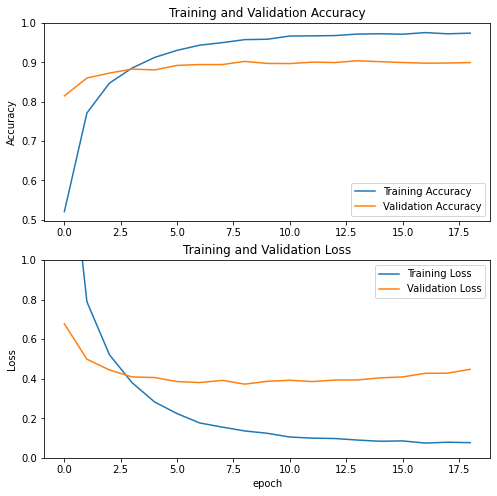

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

av_list.append((acc, val_acc, loss, val_loss))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Prediction results of ResNet with transfer learning

In [ ]:
model_loss, model_accuracy = model.evaluate(test_dataset)
print('Test accuracy :', model_accuracy, 'Test loss :', model_loss)
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict(image_batch)
classes = np.argmax(predictions, axis = 1)

print('Classes:\n', classes)

print('Labels:\n', label_batch)


158/158 [==============================] - 9s 49ms/step - loss: 0.4023 - accuracy: 0.8987
Test accuracy : 0.8986979722976685 Test loss : 0.40227699279785156
Classes:
 [40 18 43 23 33 35  1 33 28 22 25 38 36 37 43 35 29 42 37 37]
Labels:
 [40 18 43 14 33 35  1 33 28 13 24 38 36 37 43 35 29 42 37 37]


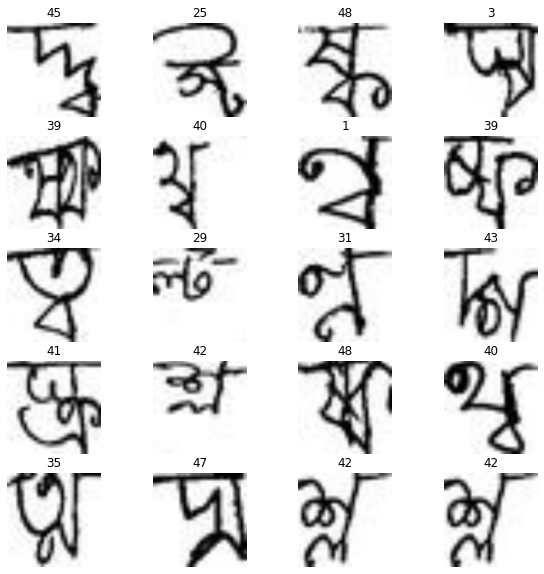

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(20):
  ax = plt.subplot(5, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[classes[i]])
  plt.axis("off")

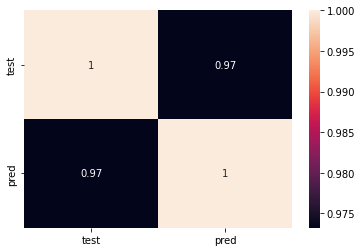

In [ ]:
dataframe = pd.DataFrame(data = {'test': label_batch, 'pred': classes})
sns.heatmap(dataframe.corr(), annot = True);



## MobileNetV2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(50, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 32000)             0         
                                                           

In [ ]:
len(model.trainable_variables)

4

In [ ]:

loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

188/188 [==============================] - 16s 69ms/step - loss: 5.3961 - accuracy: 0.0223
initial loss: 5.40
initial accuracy: 0.02


In [ ]:
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds, callbacks = [stop_early])

Epoch 1/100
375/375 [==============================] - 25s 58ms/step - loss: 1.7362 - accuracy: 0.5316 - val_loss: 0.7010 - val_accuracy: 0.7987
Epoch 2/100
375/375 [==============================] - 20s 54ms/step - loss: 0.7798 - accuracy: 0.7715 - val_loss: 0.5291 - val_accuracy: 0.8478
Epoch 3/100
375/375 [==============================] - 20s 54ms/step - loss: 0.5173 - accuracy: 0.8440 - val_loss: 0.4983 - val_accuracy: 0.8548
Epoch 4/100
375/375 [==============================] - 20s 54ms/step - loss: 0.3685 - accuracy: 0.8889 - val_loss: 0.4252 - val_accuracy: 0.8750
Epoch 5/100
375/375 [==============================] - 21s 55ms/step - loss: 0.2872 - accuracy: 0.9129 - val_loss: 0.4203 - val_accuracy: 0.8772
Epoch 6/100
375/375 [==============================] - 20s 54ms/step - loss: 0.2223 - accuracy: 0.9303 - val_loss: 0.4250 - val_accuracy: 0.8788
Epoch 7/100
375/375 [==============================] - 20s 54ms/step - loss: 0.1836 - accuracy: 0.9438 - val_loss: 0.4173 - val_ac

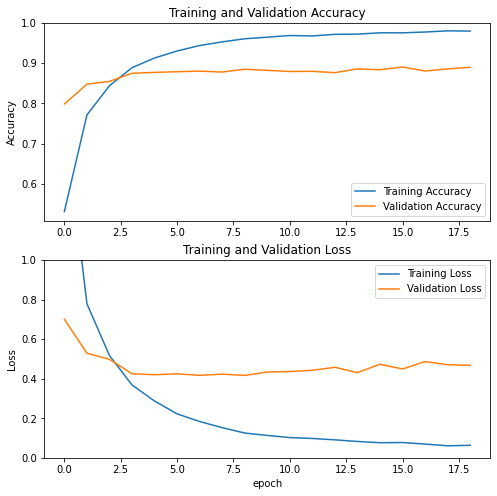

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
av_list.append((acc, val_acc, loss, val_loss))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
av_list

[([0.5202916860580444,
   0.7710833549499512,
   0.846958339214325,
   0.8852083086967468,
   0.9122083187103271,
   0.9302916526794434,
   0.9434166550636292,
   0.949833333492279,
   0.9575416445732117,
   0.9585000276565552,
   0.9666666388511658,
   0.9670833349227905,
   0.9678333401679993,
   0.971666693687439,
   0.9725000262260437,
   0.9712499976158142,
   0.9754166603088379,
   0.9723333120346069,
   0.9739583134651184],
  [0.8144999742507935,
   0.8600000143051147,
   0.8725000023841858,
   0.8826666474342346,
   0.8805000185966492,
   0.8920000195503235,
   0.8941666483879089,
   0.8941666483879089,
   0.9021666646003723,
   0.8970000147819519,
   0.8966666460037231,
   0.9003333449363708,
   0.8993333578109741,
   0.9038333296775818,
   0.9014999866485596,
   0.8993333578109741,
   0.8976666927337646,
   0.8980000019073486,
   0.8991666436195374],
  [1.8322001695632935,
   0.7892171144485474,
   0.5212397575378418,
   0.38032087683677673,
   0.28258517384529114,
   0.22356

### Prediction results of MobileNet V2 with transfer learning

In [ ]:
model_loss, model_accuracy = model.evaluate(test_dataset)
print('Test accuracy :', model_accuracy, 'Test loss :', model_loss)
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict(image_batch)
classes = np.argmax(predictions, axis = 1)

print('Classes:\n', classes)

print('Labels:\n', label_batch)


158/158 [==============================] - 21s 126ms/step - loss: 0.4457 - accuracy: 0.8885
Test accuracy : 0.8885360360145569 Test loss : 0.4457150995731354
Classes:
 [36 33  5 35  6 25 16 35 46 33 16 35 32  4  4 42 29 10 44 34]
Labels:
 [36 33  5 35  6 25 16 35 46 33 16 35 32 14  4 42 29 10 44 34]


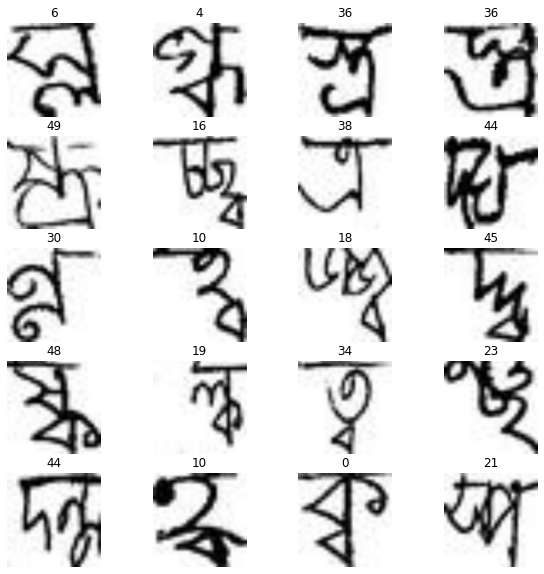

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(20):
  ax = plt.subplot(5, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[classes[i]])
  plt.axis("off")

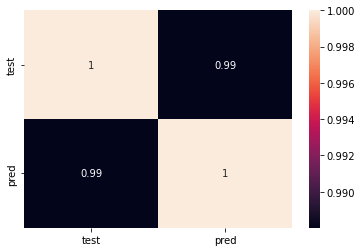

In [ ]:
dataframe = pd.DataFrame(data = {'test': label_batch, 'pred': classes})
sns.heatmap(dataframe.corr(), annot = True);



## Inception

In [ ]:
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 79, 79, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 79, 79, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [ ]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(50, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               943769

In [ ]:
len(model.trainable_variables)

4

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

94/94 [==============================] - 26s 117ms/step - loss: 5.4036 - accuracy: 0.0205
initial loss: 5.40
initial accuracy: 0.02


In [ ]:
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds, callbacks = [stop_early])

Epoch 1/100
375/375 [==============================] - 72s 84ms/step - loss: 2.9690 - accuracy: 0.2432 - val_loss: 1.8503 - val_accuracy: 0.5245
Epoch 2/100
375/375 [==============================] - 32s 84ms/step - loss: 1.9983 - accuracy: 0.4469 - val_loss: 1.3584 - val_accuracy: 0.6332
Epoch 3/100
375/375 [==============================] - 32s 86ms/step - loss: 1.6127 - accuracy: 0.5425 - val_loss: 1.1891 - val_accuracy: 0.6803
Epoch 4/100
375/375 [==============================] - 32s 86ms/step - loss: 1.4010 - accuracy: 0.5926 - val_loss: 1.0987 - val_accuracy: 0.6903
Epoch 5/100
375/375 [==============================] - 32s 86ms/step - loss: 1.2364 - accuracy: 0.6367 - val_loss: 1.0219 - val_accuracy: 0.7085
Epoch 6/100
375/375 [==============================] - 33s 88ms/step - loss: 1.1222 - accuracy: 0.6690 - val_loss: 0.9278 - val_accuracy: 0.7295
Epoch 7/100
375/375 [==============================] - 33s 88ms/step - loss: 1.0008 - accuracy: 0.6979 - val_loss: 0.9155 - val_ac

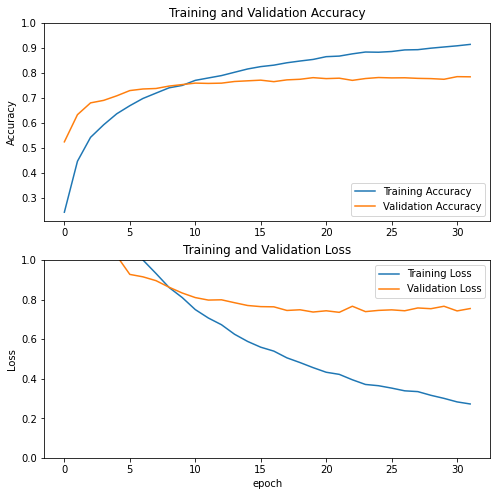

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
av_list.append((acc, val_acc, loss, val_loss))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Prediction results of Inception with transfer learning

In [ ]:
model_loss, model_accuracy = model.evaluate(test_dataset)
print('Test accuracy :', model_accuracy, 'Test loss :', model_loss)
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict(image_batch)
classes = np.argmax(predictions, axis = 1)

print('Classes:\n', classes)

print('Labels:\n', label_batch)


158/158 [==============================] - 9s 49ms/step - loss: 0.7729 - accuracy: 0.7818
Test accuracy : 0.7818354964256287 Test loss : 0.7729114890098572
Classes:
 [ 5 37 25 41 25 18 27 40 21  7 49 22 15 12 42 39 22 39 28 47]
Labels:
 [ 5 37 25 41 25 18 27 40 21  7 49 22 15 12 42 38 22 39 28 34]


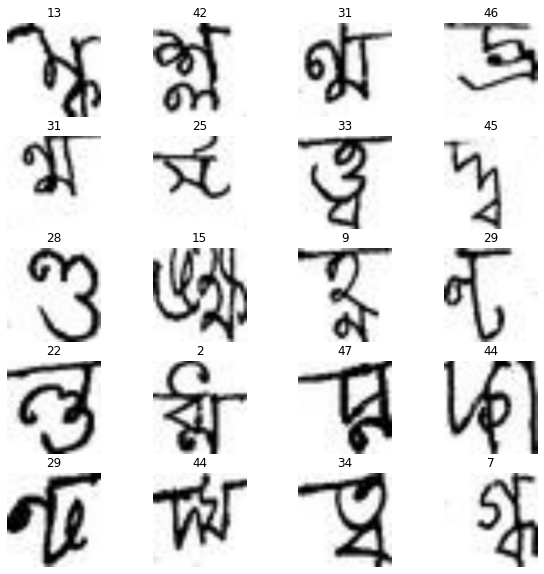

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(20):
  ax = plt.subplot(5, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[classes[i]])
  plt.axis("off")

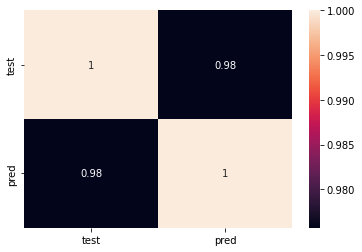

In [ ]:
dataframe = pd.DataFrame(data = {'test': label_batch, 'pred': classes})
sns.heatmap(dataframe.corr(), annot = True);



## Efficient Net

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


base_model.trainable = False
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 160, 160, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 161, 161, 3)  0           ['normalization[0][0

In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(50, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 5, 5, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense (Dense)               (None, 512)               16384512  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                25650     
                                                                 
Total params: 20,459,733
Trainable params: 16,410,162
Non-tra

In [ ]:
len(model.trainable_variables)

4

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 5, 5, 1792)       17673823  
                                                                 
 flatten (Flatten)           (None, 44800)             0         
                                                                 
 dense (Dense)               (None, 512)               22938112  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                25650     
                                                                 
Total params: 40,637,585
Trainable params: 22,963,762
Non-tra

In [ ]:
len(model.trainable_variables)

4

In [ ]:
loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds, callbacks = [stop_early])

Epoch 1/30
375/375 [==============================] - 84s 102ms/step - loss: 1.3394 - accuracy: 0.6315 - val_loss: 0.5595 - val_accuracy: 0.8425
Epoch 2/30
375/375 [==============================] - 30s 80ms/step - loss: 0.5840 - accuracy: 0.8288 - val_loss: 0.4204 - val_accuracy: 0.8793
Epoch 3/30
375/375 [==============================] - 30s 80ms/step - loss: 0.3946 - accuracy: 0.8823 - val_loss: 0.3878 - val_accuracy: 0.8868
Epoch 4/30
375/375 [==============================] - 31s 82ms/step - loss: 0.2878 - accuracy: 0.9152 - val_loss: 0.3693 - val_accuracy: 0.8915
Epoch 5/30
375/375 [==============================] - 30s 81ms/step - loss: 0.2241 - accuracy: 0.9337 - val_loss: 0.3563 - val_accuracy: 0.8970
Epoch 6/30
375/375 [==============================] - 30s 81ms/step - loss: 0.1722 - accuracy: 0.9482 - val_loss: 0.3460 - val_accuracy: 0.9025
Epoch 7/30
375/375 [==============================] - 30s 81ms/step - loss: 0.1426 - accuracy: 0.9574 - val_loss: 0.3494 - val_accuracy

In [ ]:
av_list = []

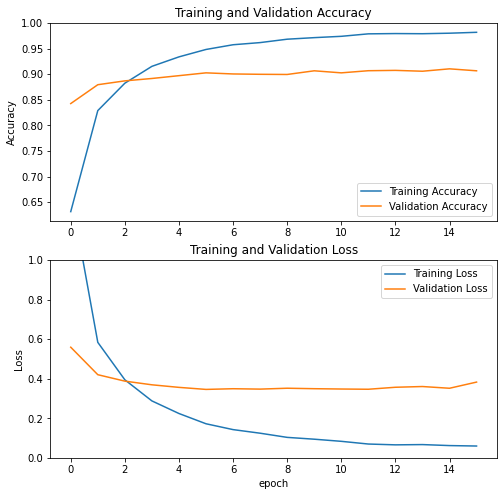

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
av_list.append((acc, val_acc, loss, val_loss))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Prediction results of Efficient Net with transfer learning

In [ ]:
model_loss, model_accuracy = model.evaluate(test_dataset)
print('Test accuracy :', model_accuracy, 'Test loss :', model_loss)
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict(image_batch)
classes = np.argmax(predictions, axis = 1)

print('Classes:\n', classes)

print('Labels:\n', label_batch)


158/158 [==============================] - 9s 53ms/step - loss: 0.3539 - accuracy: 0.9111
Test accuracy : 0.9110828638076782 Test loss : 0.35386648774147034
Classes:
 [35  2 12 18 24 22 40 26 15 12 42 34 20 44 33  9 15 39 31  7]
Labels:
 [35  2 12 18 24 22 40 26 15 12 42 34 20 44 33  9 15 39 31  7]


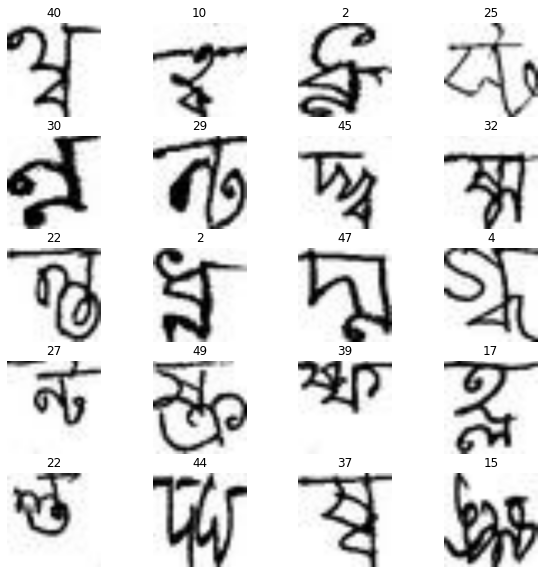

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(20):
  ax = plt.subplot(5, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[classes[i]])
  plt.axis("off")

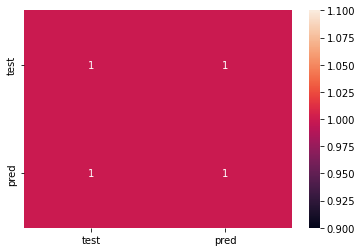

In [ ]:
dataframe = pd.DataFrame(data = {'test': label_batch, 'pred': classes})
sns.heatmap(dataframe.corr(), annot = True);

